In [ ]:
cd FashionMNIST/AlexNet

In [4]:
import numpy as np, joblib
import sys, os, random
import matplotlib.pyplot as plt
import pickle, gzip
from tqdm import tqdm,tqdm_notebook
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
batch_size = 128
seed_num = 1000

# For reproducibility when you run the file with .py
torch.cuda.is_available()
torch.manual_seed(seed_num)
torch.cuda.manual_seed(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)
torch.backends.cudnn.benchmark = True

torch.backends.cudnn.deterministic =True

In [6]:
# Data Augmentation 
train_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.2860,],[0.3205,])])
test_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.2860,],[0.3205,])])

# Splitting the training and test datasets
train_data = datasets.FashionMNIST(os.getcwd(), train=True,
                              download=True, transform=train_transform)
test_data = datasets.FashionMNIST(os.getcwd(), train=False,
                             download=True, transform=test_transform)

In [7]:
# Split the training set indices into training and validation set indices using 84:16 ratio
np.random.seed(seed_num)
len_trainset = len(train_data)
index_list = list(range(len_trainset))
np.random.shuffle(index_list)
split_index = 50000
train_indices, valid_indices =  index_list[:split_index], index_list[split_index:]

# Creating Samplers for training and validation set using the indices
np.random.seed(seed_num)
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

torch.manual_seed(seed_num)

train_iterator = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
val_iterator = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_iterator = DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [8]:
# AlexNet Model

class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1), #in_channels, out_channels, kernel_size, stride, padding
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace = True),

            nn.Conv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(256 * 6 * 6, 256),
            nn.ReLU(inplace = True),
            nn.Linear(256,256),
            nn.ReLU(inplace = True),
            nn.Linear(256, output_dim),
        )


    def forward(self, x):
        x = self.features(x)
        h = x.view(x.size(0), -1)
        x = self.classifier(h)
        
        return x

In [9]:
torch.manual_seed(seed_num)
unit=128

# Summary
model = AlexNet(10)
print("Model:\n",model)

Model:
 AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=9216

In [10]:
# Layer names
layer_name = [n for n, p in model.named_parameters()]
print(layer_name)

['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.7.weight', 'features.7.bias', 'features.9.weight', 'features.9.bias', 'features.11.weight', 'features.11.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.5.weight', 'classifier.5.bias']


In [11]:
# Loading the weights of ternary model 
model = torch.load('AlexNet_fashion_Quant.pt')
model = model.cuda()
print("Loading weights done !")

# Total number of ternary weights (+w, -w)
totalParams = 0
for i in layer_name:
  print(i,(model.state_dict()[i] !=0).sum())
  totalParams +=  (model.state_dict()[i] !=0).sum()
    
print("Total Parameters:",totalParams, '\n')

Loading weights done !
features.0.weight tensor(129, device='cuda:0')
features.0.bias tensor(23, device='cuda:0')
features.1.weight tensor(24, device='cuda:0')
features.1.bias tensor(9, device='cuda:0')
features.3.weight tensor(316, device='cuda:0')
features.3.bias tensor(32, device='cuda:0')
features.6.weight tensor(205, device='cuda:0')
features.6.bias tensor(74, device='cuda:0')
features.7.weight tensor(96, device='cuda:0')
features.7.bias tensor(67, device='cuda:0')
features.9.weight tensor(644, device='cuda:0')
features.9.bias tensor(30, device='cuda:0')
features.11.weight tensor(745, device='cuda:0')
features.11.bias tensor(49, device='cuda:0')
classifier.1.weight tensor(1497, device='cuda:0')
classifier.1.bias tensor(46, device='cuda:0')
classifier.3.weight tensor(160, device='cuda:0')
classifier.3.bias tensor(73, device='cuda:0')
classifier.5.weight tensor(141, device='cuda:0')
classifier.5.bias tensor(2, device='cuda:0')
Total Parameters: tensor(4362, device='cuda:0') 



In [12]:
# Model's performance on test set

correct_count, all_count = 0, 0
model.eval()
for images,labels in test_iterator:
      for image,label in zip(images,labels):

        if torch.cuda.is_available():
            img = image.cuda()
            lab = label.cuda()
            img = img[None,].type('torch.cuda.FloatTensor')

        with torch.no_grad():
            output_ = model(img) 

        pred_label = output_.argmax()

        if(pred_label.item()==lab.item()):
          correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Test Accuracy =", (correct_count/(all_count)))


Number Of Images Tested = 10000

Model Test Accuracy = 0.6461


In [13]:
# For each layer, model's ternary weights
state_dict = model.state_dict()

layer_distinct_weights = {}

for i in layer_name:
  imd = torch.unique(model.state_dict()[i])
  print(i+ ' hidden layer dimension', model.state_dict()[i].shape)
  print("Unique values of weight in "+ i+ " th hidden layer : ", imd)
  layer_distinct_weights[i] = imd.cpu().numpy().tolist()
  print()


features.0.weight hidden layer dimension torch.Size([32, 1, 3, 3])
Unique values of weight in features.0.weight th hidden layer :  tensor([-1.0116,  0.0000,  1.0116], device='cuda:0')

features.0.bias hidden layer dimension torch.Size([32])
Unique values of weight in features.0.bias th hidden layer :  tensor([-0.9994,  0.0000,  1.0005], device='cuda:0')

features.1.weight hidden layer dimension torch.Size([32])
Unique values of weight in features.1.weight th hidden layer :  tensor([0.0000, 1.0149], device='cuda:0')

features.1.bias hidden layer dimension torch.Size([32])
Unique values of weight in features.1.bias th hidden layer :  tensor([-1.0293,  0.0000,  0.9977], device='cuda:0')

features.3.weight hidden layer dimension torch.Size([64, 32, 3, 3])
Unique values of weight in features.3.weight th hidden layer :  tensor([-0.9972,  0.0000,  0.9989], device='cuda:0')

features.3.bias hidden layer dimension torch.Size([64])
Unique values of weight in features.3.bias th hidden layer :  te

In [14]:
# Single seed normal distribution
random.seed(seed_num)
np.random.seed(seed_num)
torch.manual_seed(seed_num)

corr_images1 = []

for i in range(4000): 
  corr_images1.append(np.random.randn(1,28,28))

corr_images1 = np.array(corr_images1)
corr_images1.shape

(4000, 1, 28, 28)

In [15]:
# Structured Patterns

random.seed(seed_num)
np.random.seed(seed_num)
torch.manual_seed(seed_num)

corr_images2 = []
a = np.identity(28) * np.random.randn(28)
corr_images2.append(a)
b = np.fliplr(a.copy()) * np.random.randn(28)
corr_images2.append(b)
c = (a+b).copy() * np.random.randn(28)
corr_images2.append(c)

# To apply [1,1] , [0,1], [1,0]
cp_file = [a,b,c]

# To apply randn
a1,b1,c1 = a.copy(), b.copy(), c.copy()
cp_file1 = [a1, b1, c1]

files = [cp_file, cp_file1]

for i in range(700):
    
    np.random.seed(i)
    choose = np.random.randint(0,2)

    # Picking row and column indices randomly
    r_idx = np.random.randint(0,28)
    c_idx = np.random.randint(0,28)

    if choose == 0:
        
        # Selecting file
        file = files[0]
        
        imd_img = file[np.random.randint(0,3)].copy()
        
        imd_img1 = file[np.random.randint(0,3)]
        
        opt =[[1,1] , [0,1], [1,0]]
        
        if np.random.randint(0,2) == 0:
        
            imd_img[r_idx,:] = np.array(opt[np.random.randint(0,3)] *14) 
            corr_images2.append(imd_img)

            imd_img[:,c_idx] = np.array(opt[np.random.randint(0,3)] *14) 
            corr_images2.append(imd_img)

        else:
            imd_img1[r_idx,:] = np.array(opt[np.random.randint(0,3)] *14) 
            corr_images2.append(imd_img1)

            imd_img1[:,c_idx] = np.array(opt[np.random.randint(0,3)] *14) 
            corr_images2.append(imd_img1)
            

    else:
        
        # Selecting file
        file = files[1]
        
        imd_img = file[np.random.randint(0,3)].copy()
        
        imd_img1 = file[np.random.randint(0,3)]
        
        opt =[[1,1] , [0,1], [1,0]]
        
        if np.random.randint(0,2) == 0:
        
            imd_img[r_idx,:] = np.array(opt[np.random.randint(0,3)] *14) * np.random.randn(28)
            corr_images2.append(imd_img)

            imd_img[:,c_idx] = np.array(opt[np.random.randint(0,3)] *14) * np.random.randn(28)
            corr_images2.append(imd_img)

        else:
            imd_img1[r_idx,:] = np.array(opt[np.random.randint(0,3)] *14) * np.random.randn(28)
            corr_images2.append(imd_img1)

            imd_img1[:,c_idx] = np.array(opt[np.random.randint(0,3)] *14) * np.random.randn(28)
            corr_images2.append(imd_img1)
    
corr_images2 = np.array(corr_images2).reshape(len(corr_images2),1,28,28)

In [16]:
corr_images2 = np.unique(corr_images2, axis=0)
len(corr_images2)

362

In [17]:
# Augmentation on structured images

random.seed(seed_num)
np.random.seed(seed_num)
torch.manual_seed(seed_num)

corr_images2_1 = []

for img in corr_images2:

    for angle in range(5,361,25):
        transform_st = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(angle), \
                                             transforms.RandomHorizontalFlip(0.40), transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images2_1.append(transform_st(img).permute(1,0,2).numpy())
        
        transform_st1 = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(angle), transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images2_1.append(transform_st1(img).permute(1,0,2).numpy())
        
        transform_st2 = transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip(0.35), transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images2_1.append(transform_st2(img).permute(1,0,2).numpy())

        transform_st3 = transforms.Compose([transforms.ToTensor(),transforms.RandomRotation(angle), transforms.RandomVerticalFlip(0.70),
                                    transforms.RandomAffine(angle),  transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images2_1.append(transform_st3(img).permute(1,0,2).numpy())

        transform_st4 = transforms.Compose([transforms.ToTensor(), transforms.RandomVerticalFlip(0.25),
                                        transforms.RandomAffine(angle), transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images2_1.append(transform_st4(img).permute(1,0,2).numpy())

        transform_st5 = transforms.Compose([transforms.ToTensor(), transforms.RandomVerticalFlip(0.45),transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images2_1.append(transform_st5(img).permute(1,0,2).numpy())

        transform_st6 = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(angle), \
                                              transforms.RandomVerticalFlip(0.35),transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images2_1.append(transform_st6(img).permute(1,0,2).numpy())

        transform_st7 = transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip(0.65), transforms.RandomAffine(angle),\
                                            transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images2_1.append(transform_st7(img).permute(1,0,2).numpy())

        transform_st8 = transforms.Compose([transforms.ToTensor(),transforms.RandomRotation(angle), transforms.RandomAffine(angle),\
                                            transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images2_1.append(transform_st8(img).permute(1,0,2).numpy())


        transform_st9 = transforms.Compose([transforms.ToTensor(),transforms.RandomRotation(angle), transforms.RandomHorizontalFlip(0.75),
                                            transforms.RandomAffine(angle),transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images2_1.append(transform_st9(img).permute(1,2,0).numpy())
            

corr_images2_1 += corr_images2.tolist()
corr_images2_1 = np.unique(corr_images2_1, axis=0)
idx = np.random.permutation(len(corr_images2_1))[:3000]
corr_images2 = corr_images2_1[idx]
corr_images2.shape

(3000, 1, 28, 28)

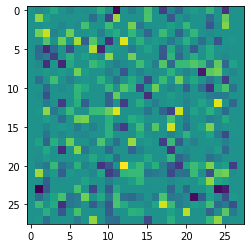

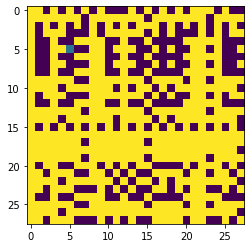

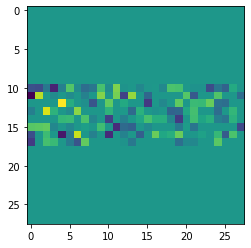

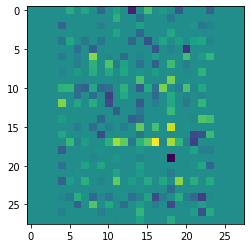

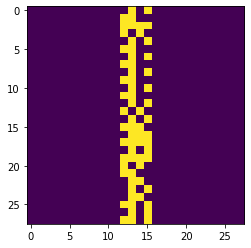

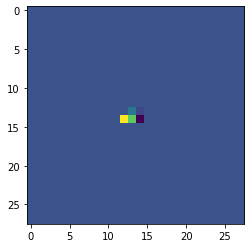

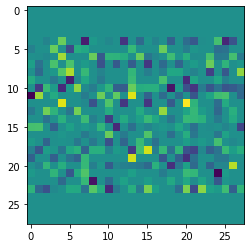

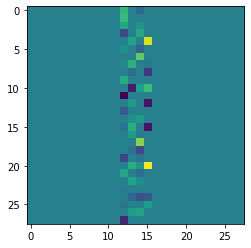

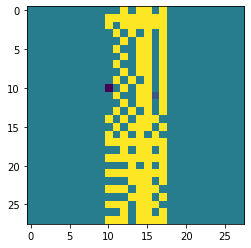

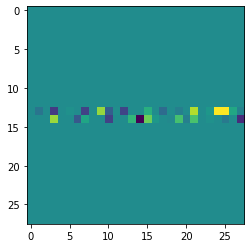

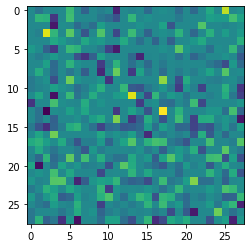

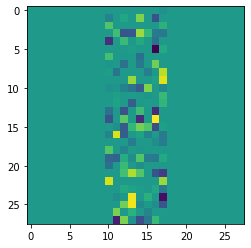

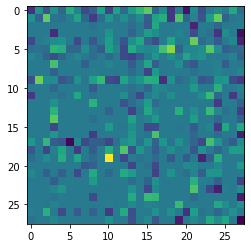

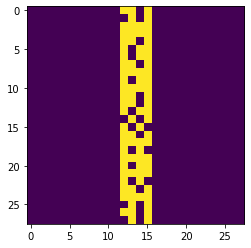

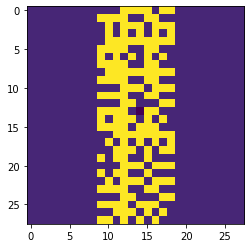

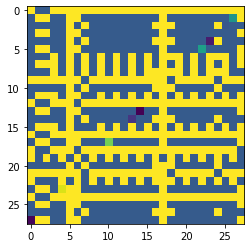

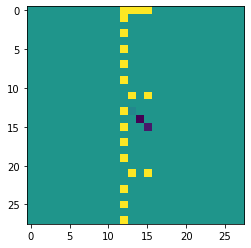

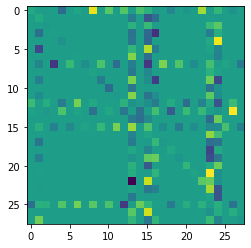

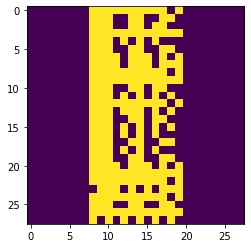

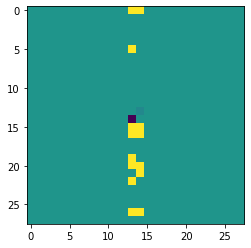

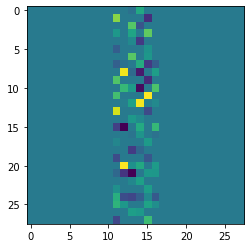

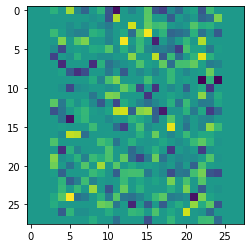

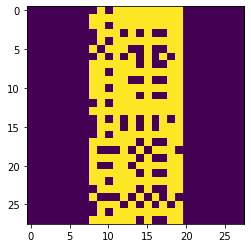

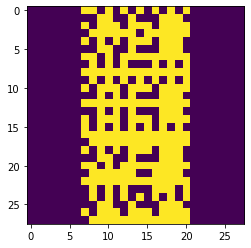

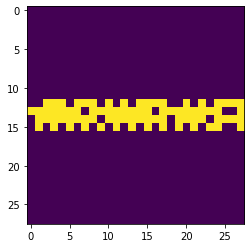

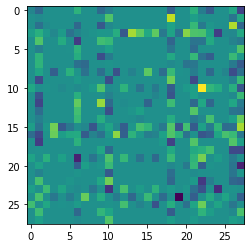

In [18]:
# Plotting some structured images
for i in range(2,28):
    plt.imshow(corr_images2[i].reshape((28,28)))
    plt.show()

In [19]:
#############
# Pixel taking randomly from 8 bits (0-255) to generate images

random.seed(seed_num)
np.random.seed(seed_num)
torch.manual_seed(seed_num)

corr_images1_ = []

for i in range(400):
    img = np.random.randint(0, 256, (1,28,28)).astype('float')/255.
    for angle in range(5,361,25):
        transform_st = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(angle), \
                                             transforms.RandomHorizontalFlip(0.25), transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images1_.append(transform_st(img).permute(1,0,2).numpy())
        
        transform_st1 = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(angle), transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images1_.append(transform_st1(img).permute(1,0,2).numpy())
        
        transform_st2 = transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip(0.35), transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images1_.append(transform_st2(img).permute(1,0,2).numpy())

        transform_st3 = transforms.Compose([transforms.ToTensor(),transforms.RandomRotation(angle), transforms.RandomVerticalFlip(0.60),
                                    transforms.RandomAffine(angle),  transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images1_.append(transform_st3(img).permute(1,0,2).numpy())


        transform_st4 = transforms.Compose([transforms.ToTensor(), transforms.RandomVerticalFlip(0.25),
                                        transforms.RandomAffine(angle), transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images1_.append(transform_st4(img).permute(1,0,2).numpy())

        transform_st5 = transforms.Compose([transforms.ToTensor(), transforms.RandomVerticalFlip(0.45),transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images1_.append(transform_st5(img).permute(1,0,2).numpy())

        transform_st6 = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(angle), \
                                              transforms.RandomVerticalFlip(0.75),transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images1_.append(transform_st6(img).permute(1,0,2).numpy())

        transform_st7 = transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip(0.13), transforms.RandomAffine(angle),\
                                            transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images1_.append(transform_st7(img).permute(1,0,2).numpy())

        transform_st8 = transforms.Compose([transforms.ToTensor(),transforms.RandomRotation(angle), transforms.RandomAffine(angle),\
                                            transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images1_.append(transform_st8(img).permute(1,0,2).numpy())


        transform_st9 = transforms.Compose([transforms.ToTensor(),transforms.RandomRotation(angle), transforms.RandomHorizontalFlip(0.60),
                                            transforms.RandomAffine(angle),transforms.Normalize([0.2860,],[0.3205,])]) 
        corr_images1_.append(transform_st9(img).permute(1,2,0).numpy())



        # transform_st6 = transforms.Compose([transforms.ToTensor(),transforms.RandomRotation(angle), transforms.RandomVerticalFlip(0.75),
        #                                     transforms.RandomAffine(angle)]) 
        # corr_images2_1.append(transform_st6(img).permute(1,2,0).numpy())

        # transform_st7 = transforms.Compose([transforms.ToTensor(), transforms.RandomVerticalFlip(0.75),
        #                                     transforms.RandomAffine(angle)]) 
        # corr_images2_1.append(transform_st7(img).permute(1,2,0).numpy())

        # transform_st8 = transforms.Compose([transforms.ToTensor(), transforms.RandomVerticalFlip(0.75),]) 
        # corr_images2_1.append(transform_st8(img).permute(1,2,0).numpy())

        # transform_st9 = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(angle), \
        #                                       transforms.RandomVerticalFlip(0.25),]) 
        # corr_images2_1.append(transform_st9(img).permute(1,2,0).numpy())



corr_images_ = np.unique(corr_images1_, axis=0)
idx = np.random.permutation(len(corr_images_))[:3000]
corr_images_ = corr_images_[idx]

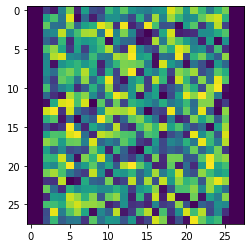

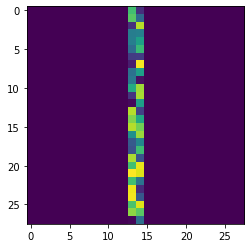

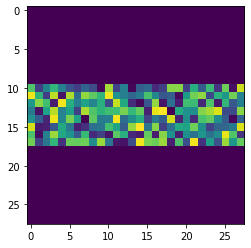

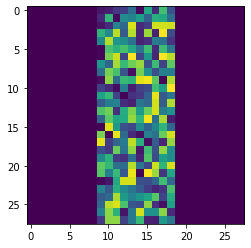

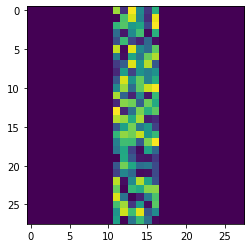

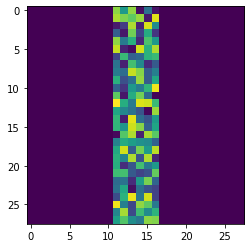

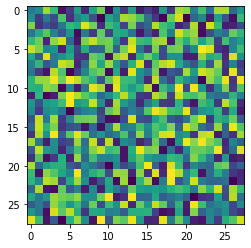

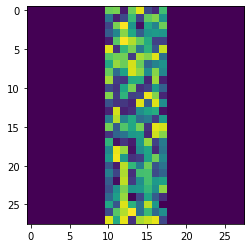

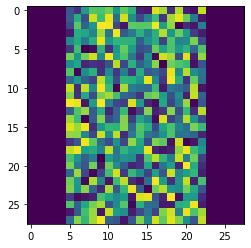

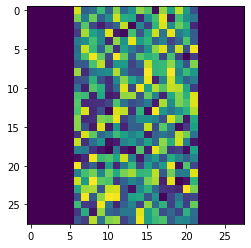

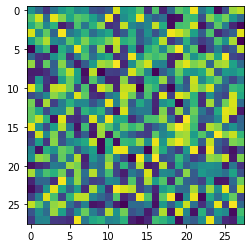

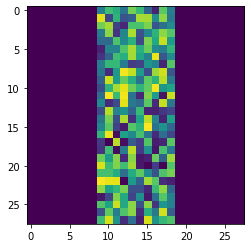

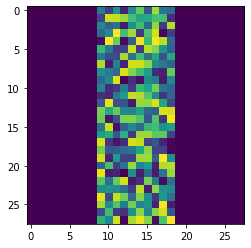

In [ ]:
for i in range(15,28):
    plt.imshow(corr_images_[i].reshape((28,28)))
    plt.show()

In [20]:
corr_images3 = np.array(corr_images_)

In [21]:
# Normal dist + Structured + Random Pixel
corr_images = np.concatenate([corr_images1, corr_images2, corr_images3])
corr_images.shape

(10000, 1, 28, 28)

In [22]:
corr_images = torch.tensor(corr_images).type(torch.FloatTensor).to('cuda')

corr_label = []
check_label = []

model.eval()
for img in corr_images:
  img = img[None,].type('torch.cuda.FloatTensor')
  with torch.no_grad():
    pred = model(img).argmax()
  corr_label.append(pred)
  check_label.append(pred.item())

digit,count = np.unique(check_label, return_counts=True)

# Model's prediction on pseudorandom images
print("\nUnique digits : ",digit)

print("\n counts : ",count)


Unique digits :  [0 1 2 3 4 5 6 7 8 9]

 counts :  [  81 1007  161  748    4 5397 2429    1  161   11]


In [23]:
pos_neg_layerwise = {}

for i in layer_name:
  b = layer_distinct_weights[i]

  if len(b) == 3:
    neg, zero, pos = b
    pos_neg_layerwise[i] = {}
    pos_neg_layerwise[i]['pos'] = pos
    pos_neg_layerwise[i]['neg'] = neg
    
  elif len(b) == 2:
    un1, un2 = b

    if un2 == 0:
      neg, zero = b
      pos_neg_layerwise[i] = {}
      pos_neg_layerwise[i]['neg'] = neg
      
    elif un1 == 0:
      zero, pos = b
      pos_neg_layerwise[i] = {}
      pos_neg_layerwise[i]['pos'] = pos

    else:
      neg, pos = b
      pos_neg_layerwise[i] = {}
      pos_neg_layerwise[i]['pos'] = pos
      pos_neg_layerwise[i]['neg'] = neg

  else:
     un = b[0] 

     if un > 0:
       pos_neg_layerwise[i] = {}
       pos_neg_layerwise[i]['pos'] = un

     elif un < 0:
       pos_neg_layerwise[i] = {}
       pos_neg_layerwise[i]['neg'] = un

     else:
       pos_neg_layerwise[i] = {}
       pos_neg_layerwise[i]['zero'] = 0


In [24]:
layer_distinct_weights

{'classifier.1.bias': [0.0, 0.9974985122680664],
 'classifier.1.weight': [-0.9924231767654419, 0.0, 0.9592171907424927],
 'classifier.3.bias': [-1.0009965896606445, 0.0, 0.9976704716682434],
 'classifier.3.weight': [-1.0025272369384766, 0.0, 0.9604441523551941],
 'classifier.5.bias': [0.0, 1.0147584676742554],
 'classifier.5.weight': [-1.0344655513763428, 0.0, 0.9815973043441772],
 'features.0.bias': [-0.9993632435798645, 0.0, 1.0005184412002563],
 'features.0.weight': [-1.011589765548706, 0.0, 1.011589765548706],
 'features.1.bias': [-1.0293270349502563, 0.0, 0.9977136850357056],
 'features.1.weight': [0.0, 1.014925479888916],
 'features.11.bias': [-0.9871994256973267, 0.0, 0.9880890846252441],
 'features.11.weight': [-0.9773134589195251, 0.0, 0.9582034945487976],
 'features.3.bias': [-1.016790747642517, 0.0, 1.0052502155303955],
 'features.3.weight': [-0.9971681833267212, 0.0, 0.9988570809364319],
 'features.6.bias': [-1.0035313367843628, 0.0, 1.0034629106521606],
 'features.6.weight

In [25]:
class PseudoData(Dataset):
    
    def __init__(self, data, label):
        
        self.data = data
        self.label = label

    def __getitem__(self, index):
        
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

corr_label = torch.tensor(corr_label).type(torch.FloatTensor).to('cuda')
pseudo_dataLoader = DataLoader(dataset = PseudoData(corr_images, corr_label), batch_size = 1000, shuffle=False) 

In [26]:
def getResult(test_example, test_label, model, st):
    model.load_state_dict(st)
    model.eval()
    with torch.no_grad():
        output_ = model(test_example.float()) 
        pred = output_.data.max(1, keepdim=True)[1]
        z = pred.eq(test_label.data.view_as(pred)).flatten()
        return torch.where(z == False)[0]

In [27]:
def populateResults(idx, batch_id, old_state, new_state, w_images, n_ic, n_oc, row, column, weight_name):
  key = 'img_id'+str(idx)+'_batch_'+str(batch_id)
  if key not in w_images:
    w_images[key] = {}
    w_images[key]['location'] = []
    w_images[key]['location'].append((weight_name, n_ic, n_oc, row, column, old_state, new_state))
    w_images[key]['weight_states'] = []
    w_images[key]['weight_states'].append(weight_name + ' : ' + str(old_state) + ' --> ' + str(new_state))

  else:
    w_images[key]['location'].append((weight_name, n_ic, n_oc, row, column, old_state, new_state))
    w_images[key]['weight_states'].append(weight_name + ' : ' + str(old_state) + ' --> ' + str(new_state))

In [28]:
def populateResults1(idx, batch_id, old_state, new_state, w_images, row, column, weight_name):
  key = 'img_id'+str(idx)+'_batch_'+str(batch_id)
  if key not in w_images:
    w_images[key] = {}
    w_images[key]['location'] = []
    w_images[key]['location'].append((weight_name, row, column, old_state, new_state))
    w_images[key]['weight_states'] = []
    w_images[key]['weight_states'].append(weight_name + ' : ' + str(old_state) + ' --> ' + str(new_state))

  else:
    w_images[key]['location'].append((weight_name, row, column, old_state, new_state))
    w_images[key]['weight_states'].append(weight_name + ' : ' + str(old_state) + ' --> ' + str(new_state))

In [29]:
# For bias weight mutation

def bias_mutation(st, superSet, w_images, img,label, batch_id, weight_name):

  if ('pos' in pos_neg_layerwise[weight_name]) and ('neg' in pos_neg_layerwise[weight_name]):
    un = pos_neg_layerwise[weight_name]['pos'], pos_neg_layerwise[weight_name]['neg']

    var_neg1 = torch.where(st==un[1])[0]
    var_1 = torch.where(st==un[0])[0]

  else:
    try:
      un = pos_neg_layerwise[weight_name]['pos']

      var_neg1 = torch.where(st==un*1000)[0]
      var_1 = torch.where(st==un)[0]

    except KeyError:
      un = pos_neg_layerwise[weight_name]['neg']

      var_neg1 = torch.where(st==un)[0]
      var_1 = torch.where(st==un*1000)[0]


  if (var_neg1.nelement() == 0.) and (var_1.nelement() == 0.):
    pass
  elif (var_neg1.nelement() > 0):
    for column, column1, column2 in zip(var_neg1, torch.flip(var_neg1, dims=(0,)), torch.roll(var_neg1, 2)):
      row = 0
      column = column.item()
      column1 = column1.item()
      column2 = column2.item()

      org_val_real = st[column].item() # For bias part

      if type(un) == tuple:
          pos, neg = un   # Positive, Negative 
          if (org_val_real < 0.) and (org_val_real == neg):
            org_val = neg
            old_state = neg

            new_state = 0.
            superSet.add((weight_name, row, column, -1, 0))

            # Injecting multiple faults (three)
            st[column] = new_state
            st[column1] = new_state
            st[column2] = new_state

            """getResult() will tell whether the passed test example is classified to other class
            or not after mutation, if it is classified to other class, then it returns True else False and 
            populateResults() will maintain the record of test examples which has been misclassified
            like location(row(which neuron), column(indices)), old_state(old_value of weight element), 
            new_state (mutated value of weight element), images"""

            
            [populateResults1(idx.item(), batch_id, -1, 0, w_images, row, column, weight_name) \
              for idx in getResult(img, label, model, state_dict)]
          
            new_state = pos
            superSet.add((weight_name, row, column, -1, 1))

            # Injecting multiple faults (three)
            st[column] = new_state
            st[column1] = new_state
            st[column2] = new_state

            [populateResults1(idx.item(), batch_id, -1, 1, w_images, row, column, weight_name) \
              for idx in getResult(img, label, model, state_dict)]
            
            st[column] = org_val
            st[column1] = org_val
            st[column2] = org_val


      ############# Negative ################################
      elif (un < 0) and (org_val_real == un):
          org_val = un
          old_state = un
          new_state = 0.
          superSet.add((weight_name, row, column, -1, 0))

          # Injecting multiple faults (two)
          st[column] = new_state
          st[column1] = new_state
          st[column2] = new_state
            
          [populateResults1(idx.item(), batch_id, -1, 0, w_images, row, column, weight_name) \
           for idx in getResult(img, label, model, state_dict)]
          
          st[column] = org_val
          st[column1] = org_val
          st[column2] = org_val

      #################################################################################################################

In [30]:
# Saving length of shape for each layer
layers_shape = {}

for i in layer_name:
  layers_shape[i] = len(state_dict[i].shape)

In [31]:
print(layers_shape)

{'features.0.weight': 4, 'features.0.bias': 1, 'features.1.weight': 1, 'features.1.bias': 1, 'features.3.weight': 4, 'features.3.bias': 1, 'features.6.weight': 4, 'features.6.bias': 1, 'features.7.weight': 1, 'features.7.bias': 1, 'features.9.weight': 4, 'features.9.bias': 1, 'features.11.weight': 4, 'features.11.bias': 1, 'classifier.1.weight': 2, 'classifier.1.bias': 1, 'classifier.3.weight': 2, 'classifier.3.bias': 1, 'classifier.5.weight': 2, 'classifier.5.bias': 1}


In [32]:
# Injecting fault by mutating the ternary weight and check whether it is classified to other class than before by the model. 

fetchimg_totImg_coverage_totCov = []

w_images = {}
superSet = set()


batch_id = 0
for img,label  in tqdm(pseudo_dataLoader):

    for weight_name in layer_name:

        # Selecting hidden layer to iterate its weight elements
        st = state_dict[weight_name]


        if ('bias' in weight_name) or (layers_shape[weight_name] == 1):
          bias_mutation(st, superSet, w_images, img,label, batch_id, weight_name)
          continue

        if ('conv' in weight_name) or (layers_shape[weight_name] == 4):

          ic, oc, k,k1 = st.shape # ic = in_channel, oc= out_channel, k and k1 is the number of rows and columns of a kernel

          for n_ic in range(ic):
            for n_oc in range(oc):
              kt =  st[n_ic][n_oc] # Fetching Kernel matrix or tensor

              # Iterating number of neurons for the selected hidden layer
              for row in range(k):

                # Fetching indices for -w and w weight value for the selected kernel
                """Since each kernel has weight vector, so by fetching indices
                we will come to know, which indices of the kernel contains weights -w or w weight"""

                ###########################################################################################

                if ('pos' in pos_neg_layerwise[weight_name]) and ('neg' in pos_neg_layerwise[weight_name]):
                  un = pos_neg_layerwise[weight_name]['pos'], pos_neg_layerwise[weight_name]['neg']

                  var_neg1 = torch.where(kt[row]==un[1])[0]
                  var_1 = torch.where(kt[row]==un[0])[0]

                else:
                  try:
                    un = pos_neg_layerwise[weight_name]['pos']

                    var_neg1 = torch.where(kt[row]==un*1000)[0]
                    var_1 = torch.where(kt[row]==un)[0]

                  except KeyError:
                    un = pos_neg_layerwise[weight_name]['neg']

                    var_neg1 = torch.where(kt[row]==un)[0]
                    var_1 = torch.where(kt[row]==un*1000)[0]

                ##########################################################################################
      

                if (var_neg1.nelement() == 0.) and (var_1.nelement() == 0.):
                  continue
                elif (var_neg1.nelement() > 0):
                  for column, column1, column2 in zip(var_neg1, torch.flip(var_neg1, dims=(0,)), torch.roll(var_neg1, 2)):

                    column = column.item()
                    column1 = column1.item()
                    column2 = column2.item()

                    org_val_real = kt[row][column].item()

                    ##################################################################################################################

                    if type(un) == tuple:
                      pos, neg = un  # Positive, Negative

                      if (org_val_real < 0.) and (org_val_real == neg):
                        org_val = neg
                        old_state = neg
                        new_state = 0.
                        superSet.add((weight_name, n_ic, n_oc, row, column, -1, 0))

                        # Injecting multiple faults (three)
                        st[n_ic][n_oc][row][column] = new_state
                        st[n_ic][n_oc][row][column1] = new_state
                        st[n_ic][n_oc][row][column2] = new_state
                        
                        """getResult() will tell whether the passed test example is classified to other class
                        or not after mutation, if it is classified to other class, then it returns True else False and 
                        populateResults() will maintain the record of test examples which has been misclassified
                        like location(row(which neuron), column(indices)), old_state(old_value of weight element), 
                        new_state (mutated value of weight element), images"""

                        
                        [populateResults(idx.item(), batch_id, -1, 0, w_images, n_ic, n_oc, row, column, weight_name) \
                         for idx in getResult(img, label, model, state_dict)]
                        
                        new_state = pos
                        superSet.add((weight_name, n_ic, n_oc, row, column, -1, 1))

                        # Injecting multiple faults (three)
                        st[n_ic][n_oc][row][column] = new_state
                        st[n_ic][n_oc][row][column1] = new_state
                        st[n_ic][n_oc][row][column2] = new_state

                            
                        [populateResults(idx.item(), batch_id, -1, 1, w_images, n_ic, n_oc, row, column, weight_name) \
                         for idx in getResult(img, label, model, state_dict)]
                        st[n_ic][n_oc][row][column] = org_val # Setting back to original value
                        st[n_ic][n_oc][row][column1] = org_val
                        st[n_ic][n_oc][row][column2] = org_val
                    



                    elif (un < 0) and (org_val_real == un): ########################## Negative ###########################################
                      org_val = un
                      old_state = un
                      new_state = 0.
                      superSet.add((weight_name,  n_ic, n_oc, row, column, -1, 0))

                      # Injecting multiple faults (three)
                      st[n_ic][n_oc][row][column] = new_state
                      st[n_ic][n_oc][row][column1] = new_state
                      st[n_ic][n_oc][row][column2] = new_state
                        
                      [populateResults(idx.item(), batch_id, -1, 0, w_images, n_ic, n_oc, row, column, weight_name) \
                       for idx in getResult(img, label, model, state_dict)]
                      
                      st[n_ic][n_oc][row][column] = org_val
                      st[n_ic][n_oc][row][column1] = org_val
                      st[n_ic][n_oc][row][column2] = org_val


    
            
        
        # For fully connected layers
        elif layers_shape[weight_name] == 2:
          rows = state_dict[weight_name].shape[0]

          # Iterating number of neurons for the selected hidden layer
          for row in range(rows):

            # Fetching indices for -w and w weight value for the selected neuron
            """Since each neuron has weight vector, so by fetching indices
            we will come to know, which indices of the neuron contains weights -w or w weight"""

            #########################################################################################

            if ('pos' in pos_neg_layerwise[weight_name]) and ('neg' in pos_neg_layerwise[weight_name]):
              un = pos_neg_layerwise[weight_name]['pos'], pos_neg_layerwise[weight_name]['neg']

              var_neg1 = torch.where(st[row]==un[1])[0]
              var_1 = torch.where(st[row]==un[0])[0]

            else:
              try:
                un = pos_neg_layerwise[weight_name]['pos']

                var_neg1 = torch.where(st[row]==un*1000)[0]
                var_1 = torch.where(st[row]==un)[0]

              except KeyError:
                un = pos_neg_layerwise[weight_name]['neg']

                var_neg1 = torch.where(st[row]==un)[0]
                var_1 = torch.where(st[row]==un*1000)[0]


            #########################################################################################


            if (var_neg1.nelement() == 0.) and (var_1.nelement() == 0.):
              continue
            elif (var_neg1.nelement() > 0):
              for column, column1, column2 in zip(var_neg1, torch.flip(var_neg1, dims=(0,)), torch.roll(var_neg1, 2)):

                column = column.item()
                column1 = column1.item()
                column2 = column2.item()

                org_val_v1 = st[row][column].item()


                #########################################################################################

                if type(un) == tuple:
                  pos, neg = un  # Positive, Negative

                  if (org_val_v1 < 0.) and (neg == org_val_v1):

                    org_val = neg
                    old_state = neg
                    new_state = 0.
                    superSet.add((weight_name, row, column, -1, 0))

                    # Injecting multiple faults (three)
                    st[row][column] = new_state
                    st[row][column1] = new_state
                    st[row][column2] = new_state
                    
                    [populateResults1(idx.item(), batch_id, -1, 0, w_images, row, column, weight_name) \
                     for idx in getResult(img, label, model, state_dict)]
                    
                    new_state = pos
                    superSet.add((weight_name, row, column, -1, 1))

                    # Injecting multiple faults (three)
                    st[row][column] = new_state
                    st[row][column1] = new_state
                    st[row][column2] = new_state
                        
                    [populateResults1(idx.item(), batch_id, -1, 1, w_images, row, column, weight_name) \
                     for idx in getResult(img, label, model, state_dict)]
                    st[row][column] = org_val
                    st[row][column1] = org_val
                    st[row][column2] = org_val


 
                elif (un < 0) and (un == org_val_v1):  ################# Negative ###############################################################
                  org_val = un  
                  old_state = un
                  new_state = 0.
                  superSet.add((weight_name, row, column, -1, 0))

                  # Injecting multiple faults (three)
                  st[row][column] = new_state
                  st[row][column1] = new_state
                  st[row][column2] = new_state
                    
                  [populateResults1(idx.item(), batch_id, -1, 0, w_images, row, column, weight_name) \
                   for idx in getResult(img, label, model, state_dict)]

                  st[row][column] = org_val
                  st[row][column1] = org_val
                  st[row][column2] = org_val



    batch_id += 1


    # Fetching locations and total number of images
    ################################################

    print(f"Total number of elements in superSet is : {len(superSet)}.",'\n')

    # joblib.dump(w_images, open('w_images_'+str(batch_id)+'.pkl','wb')) 

    image_locCounts = [] # (image_id,locationCounts)

    for img in w_images.keys():
        locCounts = len(w_images[img]['location'])
        image_locCounts.append((locCounts,img))
            
    image_locCounts.sort(reverse=True)


    netSetOfImages = []
    progressingSet = []
    max_locCounts_img = image_locCounts[0][1] # An image that has encompassed maximum locations.

    netSetOfImages.append(max_locCounts_img)
    progressingSet += set(w_images[max_locCounts_img]['location'])


    for i in range(1,len(image_locCounts)):
        img = image_locCounts[i][1]
        locs = w_images[img]['location']

        if set(locs).issubset(progressingSet):
            pass
        else:
            progressingSet += list(set(locs) - set(progressingSet))
            netSetOfImages.append(img)


    if set(superSet).issubset(progressingSet):
        print("All match done!")
    else:
        print("There are {} locations that did not match.".format(len(set(superSet) - set(progressingSet))))

    print()
    print("Total number of locations {} are encompassed out of {}.".format(len(set(progressingSet)), len(superSet)))


    print("Total number of elements in a weight matrix is ", len(superSet))

    print("Total number of images fetched ",len(netSetOfImages),'\n')

    fetchimg_totImg_coverage_totCov.append(( len(netSetOfImages), len(set(progressingSet)), len(superSet) ))

    # joblib.dump(fetchimg_totImg_coverage_totCov, open('res'+str(numImgs)+'.pkl','wb')) 

    # Superset 
    # joblib.dump(superSet, open('superSet.pkl','wb'))    

                
      
    print("Output \n")
    print(fetchimg_totImg_coverage_totCov)

    #joblib.dump(fetchimg_totImg_coverage_totCov, open('op_128.pkl', 'wb'))


  0%|          | 0/10 [00:00<?, ?it/s]

Total number of elements in superSet is : 2566. 



 10%|█         | 1/10 [02:00<18:04, 120.46s/it]

There are 240 locations that did not match.

Total number of locations 2326 are encompassed out of 2566.
Total number of elements in a weight matrix is  2566
Total number of images fetched  24 

Output 

[(24, 2326, 2566)]
Total number of elements in superSet is : 2566. 



 20%|██        | 2/10 [04:00<16:03, 120.42s/it]

There are 112 locations that did not match.

Total number of locations 2454 are encompassed out of 2566.
Total number of elements in a weight matrix is  2566
Total number of images fetched  33 

Output 

[(24, 2326, 2566), (33, 2454, 2566)]
Total number of elements in superSet is : 2566. 



 30%|███       | 3/10 [06:01<14:03, 120.43s/it]

There are 106 locations that did not match.

Total number of locations 2460 are encompassed out of 2566.
Total number of elements in a weight matrix is  2566
Total number of images fetched  36 

Output 

[(24, 2326, 2566), (33, 2454, 2566), (36, 2460, 2566)]
Total number of elements in superSet is : 2566. 



 40%|████      | 4/10 [08:02<12:03, 120.54s/it]

There are 104 locations that did not match.

Total number of locations 2462 are encompassed out of 2566.
Total number of elements in a weight matrix is  2566
Total number of images fetched  37 

Output 

[(24, 2326, 2566), (33, 2454, 2566), (36, 2460, 2566), (37, 2462, 2566)]
Total number of elements in superSet is : 2566. 



 50%|█████     | 5/10 [10:02<10:02, 120.42s/it]

There are 81 locations that did not match.

Total number of locations 2485 are encompassed out of 2566.
Total number of elements in a weight matrix is  2566
Total number of images fetched  47 

Output 

[(24, 2326, 2566), (33, 2454, 2566), (36, 2460, 2566), (37, 2462, 2566), (47, 2485, 2566)]
Total number of elements in superSet is : 2566. 



 60%|██████    | 6/10 [12:02<08:01, 120.40s/it]

There are 78 locations that did not match.

Total number of locations 2488 are encompassed out of 2566.
Total number of elements in a weight matrix is  2566
Total number of images fetched  42 

Output 

[(24, 2326, 2566), (33, 2454, 2566), (36, 2460, 2566), (37, 2462, 2566), (47, 2485, 2566), (42, 2488, 2566)]
Total number of elements in superSet is : 2566. 



 70%|███████   | 7/10 [14:03<06:01, 120.50s/it]

There are 72 locations that did not match.

Total number of locations 2494 are encompassed out of 2566.
Total number of elements in a weight matrix is  2566
Total number of images fetched  35 

Output 

[(24, 2326, 2566), (33, 2454, 2566), (36, 2460, 2566), (37, 2462, 2566), (47, 2485, 2566), (42, 2488, 2566), (35, 2494, 2566)]
Total number of elements in superSet is : 2566. 



 80%|████████  | 8/10 [16:05<04:01, 120.92s/it]

There are 65 locations that did not match.

Total number of locations 2501 are encompassed out of 2566.
Total number of elements in a weight matrix is  2566
Total number of images fetched  37 

Output 

[(24, 2326, 2566), (33, 2454, 2566), (36, 2460, 2566), (37, 2462, 2566), (47, 2485, 2566), (42, 2488, 2566), (35, 2494, 2566), (37, 2501, 2566)]
Total number of elements in superSet is : 2566. 



 90%|█████████ | 9/10 [18:07<02:01, 121.44s/it]

There are 62 locations that did not match.

Total number of locations 2504 are encompassed out of 2566.
Total number of elements in a weight matrix is  2566
Total number of images fetched  34 

Output 

[(24, 2326, 2566), (33, 2454, 2566), (36, 2460, 2566), (37, 2462, 2566), (47, 2485, 2566), (42, 2488, 2566), (35, 2494, 2566), (37, 2501, 2566), (34, 2504, 2566)]
Total number of elements in superSet is : 2566. 



100%|██████████| 10/10 [20:10<00:00, 121.00s/it]

There are 61 locations that did not match.

Total number of locations 2505 are encompassed out of 2566.
Total number of elements in a weight matrix is  2566
Total number of images fetched  37 

Output 

[(24, 2326, 2566), (33, 2454, 2566), (36, 2460, 2566), (37, 2462, 2566), (47, 2485, 2566), (42, 2488, 2566), (35, 2494, 2566), (37, 2501, 2566), (34, 2504, 2566), (37, 2505, 2566)]


In [33]:
# Fault coverage
fetchimg_totImg_coverage_totCov[-1][1]/fetchimg_totImg_coverage_totCov[-1][2]

0.9762275915822292